In [1]:
import time
import sys
import pickle
import torch
import anndata
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import scvelo as scv
import scanpy
import scipy

from torch import optim
from veloproj import *
from IPython import display
from matplotlib import pyplot as plt

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-5', 
                               '--n-epochs', '20000', 
                               '--data-dir', '/data/users/cqiao/notebooks/data/organoids.hdf5',
                               '--exp-name', 'baseline_scEU',
                               '--device', 'cuda:3'
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("3", "1"), ("3", "2")]
k_cluster = "monocle_branch_id"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, model, lr=args.lr, weight_decay=args.weight_decay):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    model.train()
    i, losses = 0, [sys.maxsize]
    while i < args.n_epochs:
        i += 1
        loss = train_step_AE([tensor_u, tensor_s, tensor_x], model, optimizer)                
        losses.append(loss)
        if i % args.log_interval == 0:
            plt.plot(losses[1:])
            display.clear_output(wait=True)
            plt.show()
            print("Train Epoch: {:2d} Loss: {:.6f}"
                  .format(i, losses[-1]))
            
            if abs(np.mean(losses[-11:]) - losses[-1]) < args.conv_thred:
                print("Seems converging, stop training.")
                break
    
    plt.plot(losses[1:])
    display.clear_output(wait=True)
    plt.show()
    print(losses[-1])
    return model

In [6]:
adata = scanpy.read_h5ad(args.data_dir)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.68 0.32]
Filtered out 3746 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
computing neighbors
    finished (0:00:13) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 3831 × 2000
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'rotated_umap1', 'rotated_umap2', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'con

computing velocities
    finished (0:00:00) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:06) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_scEU_stochastical.png


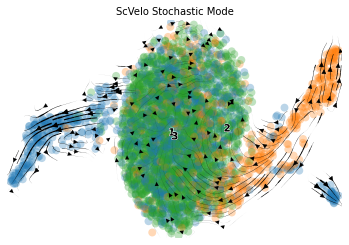

# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.15114777, ('3', '2'): 0.08071256}
Total Mean: 0.11593016237020493
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.79889697, ('3', '2'): 0.8207498}
Total Mean: 0.8098233938217163
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): 0.10821400009650162, ('3', '2'): 0.07437119337077965}
Total Mean: 0.09129259673364062
# In-cluster Coherence
{'1': 0.8049664, '2': 0.8545274, '3': 0.83366334}
Total Mean: 0.8310523629188538
# In-cluster Confidence
{'1': 0.7199635048156345, '2': 0.7906047247751308, '3': 0.7805492314829755}
Total Mean: 0.7637058203579136


In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity')
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis='X_umap', color=['monocle_branch_id'],
                                title='ScVelo Stochastic Mode', save="scEU_stochastical.png")
exp_metrics['stc_mode'] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

In [8]:
spliced = adata.layers['Ms']
unspliced = adata.layers['Mu']
tensor_s, tensor_u = torch.FloatTensor(spliced).to(device), torch.FloatTensor(unspliced).to(device)
tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

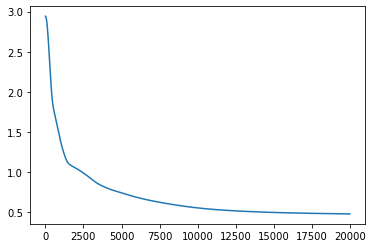

0.4766170382499695
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:02) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


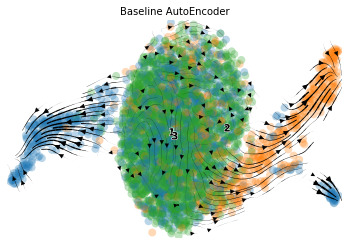

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.0784588, ('3', '2'): 0.09961809}
Total Mean: 0.08903844654560089
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.9886922, ('3', '2'): 0.99105656}
Total Mean: 0.9898743629455566
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): -0.0581404293520381, ('3', '2'): 0.06470344064780148}
Total Mean: 0.00328150564788169
# In-cluster Coherence
{'1': 0.9781404, '2': 0.9895155, '3': 0.9913371}
Total Mean: 0.9863309860229492
# In-cluster Confidence
{'1': 0.9504711684209621, '2': 0.9642697634938101, '3': 0.9700768785690194}
Total Mean: 0.9616059368279305


In [9]:
def expBaseAE(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    
    model = get_baseline_AE(in_dim, z_dim, h_dim).to(device)
    model = main_AE(args, model)
    x = model.encoder(tensor_x).detach().cpu().numpy()
    s = model.encoder(tensor_s).detach().cpu().numpy()
    u = model.encoder(tensor_u).detach().cpu().numpy()
    v = model.encoder(tensor_s + tensor_v).detach().cpu().numpy() - s
    
    adata = new_adata(adata, x, s, u, v, False)
    
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['monocle_branch_id'],
                                    title="Baseline AutoEncoder",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expBaseAE(adata, exp_metrics)


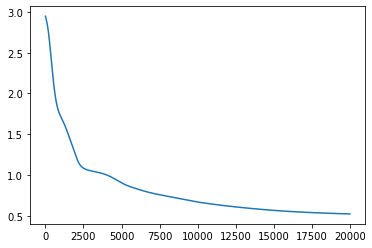

0.5225660800933838
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:02) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


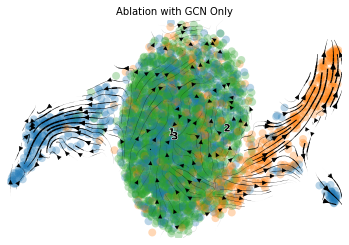

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.04845693, ('3', '2'): 0.028419562}
Total Mean: 0.03843824565410614
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.93160784, ('3', '2'): 0.93781286}
Total Mean: 0.9347103834152222
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): 0.05014572132821377, ('3', '2'): 0.06405869953068252}
Total Mean: 0.057102210429448144
# In-cluster Coherence
{'1': 0.92694527, '2': 0.9393426, '3': 0.94305855}
Total Mean: 0.9364488124847412
# In-cluster Confidence
{'1': 0.9187372518296273, '2': 0.9277995093611675, '3': 0.9404465892718206}
Total Mean: 0.9289944501542052


In [10]:
def expAblationCohAgg(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    conn = adata.obsp['connectivities']
    nb_indices = adata.uns['neighbors']['indices']
    xs, ys = np.repeat(range(n_cells), nb_indices.shape[1]-1), nb_indices[:, 1:].flatten()
    edge_weight = torch.FloatTensor(conn[xs,ys]).view(-1).to(device)
    edge_index = torch.LongTensor(np.vstack([xs.reshape(1,-1), xs.reshape(1, -1)])).to(device)
    
    model = get_ablation_CohAgg(edge_index,
                                edge_weight,
                                in_dim,
                                z_dim,
                                h_dim,
                                device)
    model = main_AE(args, model)
    
    x = model.encoder(tensor_x).detach().cpu().numpy()
    s = model.encoder(tensor_s).detach().cpu().numpy()
    u = model.encoder(tensor_u).detach().cpu().numpy()
    v = model.encoder(tensor_s + tensor_v).detach().cpu().numpy() - s
    
    adata = new_adata(adata, x, s, u, v, False)
    
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['monocle_branch_id'],
                                    title="Ablation with GCN Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation GCN Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationCohAgg(adata, exp_metrics)

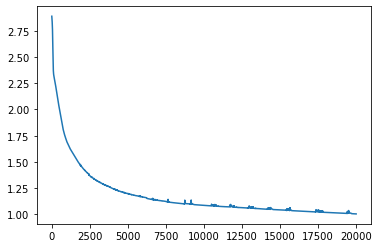

1.0032318830490112
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:02) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


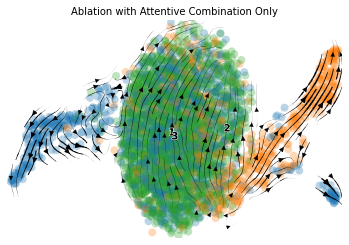

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.17674518, ('3', '2'): 0.08437016}
Total Mean: 0.13055767118930817
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.9887782, ('3', '2'): 0.9902432}
Total Mean: 0.9895106554031372
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): 1.9180143129270283e-05, ('3', '2'): 0.03785216291636372}
Total Mean: 0.018935671529746498
# In-cluster Coherence
{'1': 0.9803356, '2': 0.98072, '3': 0.9903889}
Total Mean: 0.9838147759437561
# In-cluster Confidence
{'1': 0.97758960911375, '2': 0.9768609335527529, '3': 0.9896498299356716}
Total Mean: 0.9813667908673915


In [11]:
def expAblationAttComb(adata, exp_metrics):
    from sklearn.decomposition import PCA
    n_cells, n_genes = adata.X.shape
    z_dim = args.z_dim 
    g_rep_dim = args.g_rep_dim
    h_dim = args.h_dim
    k_dim = args.k_dim
    
    G_embeddings = PCA(n_components=g_rep_dim).fit_transform(adata.X.T.toarray())
    
    model = get_ablation_attcomb(
        z_dim,
        n_genes,
        n_cells,
        h_dim,
        k_dim,
        G_embeddings,
        g_rep_dim,
        device)
    model = main_AE(args, model, lr=3e-6)
    
    x = model.encoder(tensor_x).detach().cpu().numpy()
    s = model.encoder(tensor_s).detach().cpu().numpy()
    u = model.encoder(tensor_u).detach().cpu().numpy()
    v = model.encoder(tensor_s + tensor_v).detach().cpu().numpy() - s
    
    adata = new_adata(adata, x, s, u, v, False)
    
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['monocle_branch_id'],
                                    title="Ablation with Attentive Combination Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation AttComb Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationAttComb(adata, exp_metrics)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:02) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


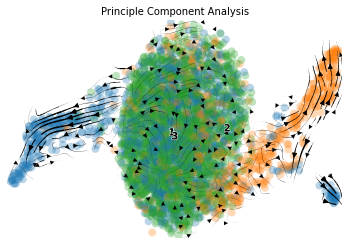

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.040824205, ('3', '2'): 0.02165442}
Total Mean: 0.031239312142133713
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.91634077, ('3', '2'): 0.92505807}
Total Mean: 0.920699417591095
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): 0.021880208993391412, ('3', '2'): 0.0674338665327561}
Total Mean: 0.044657037763073754
# In-cluster Coherence
{'1': 0.91276985, '2': 0.93342626, '3': 0.93158925}
Total Mean: 0.9259284138679504
# In-cluster Confidence
{'1': 0.9022841012931817, '2': 0.919448513191248, '3': 0.9279764263487574}
Total Mean: 0.9165696802777291


In [12]:
def expPCA(adata, exp_metrics):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(pca, 
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy()
                                  )
    
    adata = new_adata(adata, x, s, u, v, False)
    
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['monocle_branch_id'],
                                    title="Principle Component Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline PCA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
     
expPCA(adata, exp_metrics)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:02) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


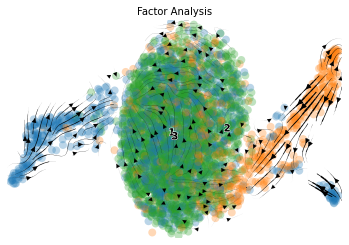

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.031080319, ('3', '2'): 0.038021334}
Total Mean: 0.034550826996564865
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.749684795262727, ('3', '2'): 0.758269175787889}
Total Mean: 0.753976985525308
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): -0.037099113938482316, ('3', '2'): -0.017975213436720736}
Total Mean: -0.027537163687601528
# In-cluster Coherence
{'1': 0.7921281916725486, '2': 0.7969233530711025, '3': 0.7786947928797763}
Total Mean: 0.7892487792078091
# In-cluster Confidence
{'1': 0.7576546149879152, '2': 0.7539560890652871, '3': 0.7693827512059175}
Total Mean: 0.7603311517530399


In [13]:
def expFA(adata, exp_metrics):
    from sklearn.decomposition import FactorAnalysis
    method = FactorAnalysis(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(method,
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy()
                                  )
    
    adata = new_adata(adata, x, s, u, v, False)
    
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['monocle_branch_id'],
                                    title="Factor Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline FA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")

expFA(adata, exp_metrics)

In [17]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)